In [8]:
import os 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt



In [9]:
# file_dir = os.path.join('C:\\', 'Users', 'cruze', 'Documents', 'CS677', 'finalProj')
file_name = os.path.join(os.getcwd(), 'SP500.csv')

df = pd.read_csv(file_name)

df['Date'] = pd.to_datetime(df['Date'])
df = df.rename(columns={'Adj Close': 'Price'})
df['pct_change'] = df['Price'].pct_change()
df['pct_tmrw'] = df['pct_change'].shift(-1)
df = df[['Date','Price','pct_change','pct_tmrw']]

In [10]:
#  set label thresholds for "good" and "bad" S&P days
defGood = .005
defBad = -.003
df['goodDay'] = df['pct_tmrw'] > df['pct_tmrw'].std()*.1

label = []
for i in range(0,int(len(df))):
    if df.loc[i,'pct_tmrw'] > defGood:
        label.append('Good')
    elif df.loc[i,'pct_tmrw'] < defBad:
        label.append('Bad')
    else:
        label.append('Neutral')

df['label'] = label

df = df.dropna()

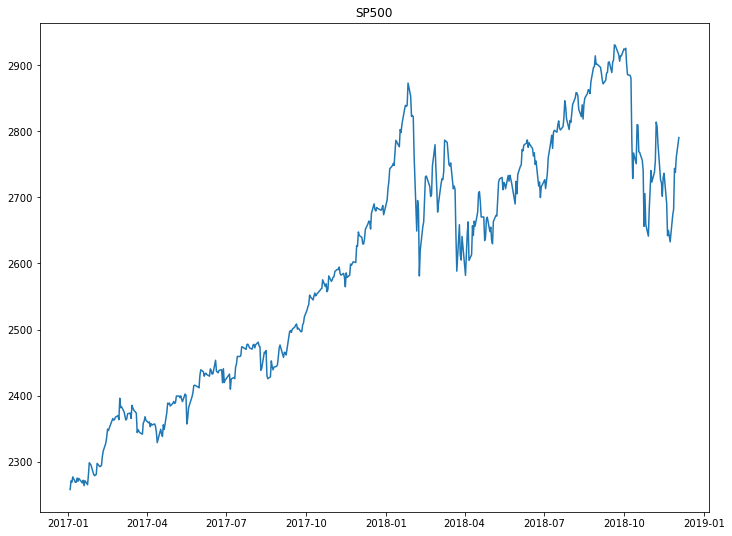

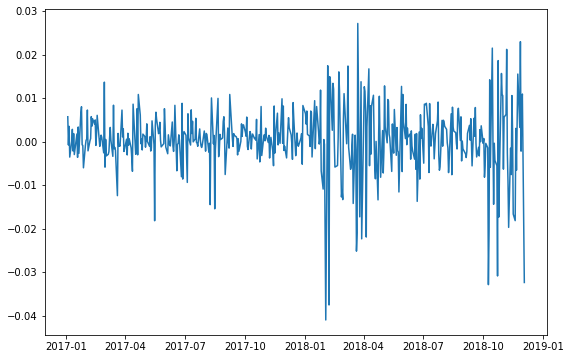

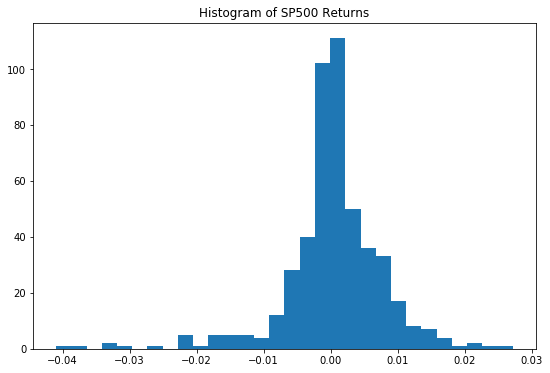

count    484.000000
mean       0.000398
std        0.007565
min       -0.040979
25%       -0.002168
50%        0.000576
75%        0.003706
max        0.027157
Name: pct_tmrw, dtype: float64


In [11]:
#  presidential mask
mask = ((df['Date'] >= '2017-01-01') & (df['Date'] <= '2018-12-03'))
df = df.loc[mask]
df = df.reset_index(drop=True)

outpath = os.path.join(os.getcwd(), 'SP500_prepped.csv')

out = pd.DataFrame(data=df)
out.to_csv(outpath, index_label=False)

X = df['Date']
y = df['Price']

plt.plot(X,y)
plt.title('SP500', fontdict=None, loc='center', pad=None)
plt.rcParams["figure.figsize"] = [9,6]
plt.show()

y = df['pct_tmrw']

plt.plot(X,y)
plt.rcParams["figure.figsize"] = [9,6]
plt.show()

plt.hist(df['pct_tmrw'], bins=30)
plt.title('Histogram of SP500 Returns', fontdict=None, loc='center', pad=None)

plt.rcParams["figure.figsize"] = [9,6]
plt.show()

print(df['pct_tmrw'].describe())

In [4]:
import json

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [5]:
#  paramters
no_features = 500
no_topics = 25

#  display paramters 
no_top_words = 10
no_top_documents = 10

file_name = os.path.join('trumptweets.json')

json_data = open(file_name, encoding="utf-8-sig").read()
data = json.loads(json_data)

dfFull = pd.io.json.json_normalize(data)

dfFull['created_at'] = pd.to_datetime(dfFull['created_at'])

maskPres = dfFull['created_at'] > '2017-01-01'

df = dfFull[maskPres]

df = df.rename(columns={'created_at': 'Date'})


In [6]:
#takeout retweets
df = df[df['is_retweet'] == False]
df = df.reset_index(drop=True)

dfText = df['text']


#  LDA pre-processing
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(dfText)
tf_feature_names = tf_vectorizer.get_feature_names()

llions of additional dollars are being spent by NATO countries since my visit last year, at my request, but it isn’t nearly enough. U.S. spends too much. Europe’s borders are BAD! Pipeline dollars to Russia are not acceptable!
There is no reason for these massive, deadly and costly forest fires in California except that forest management is so poor. Billions of dollars are given each year, with so many lives lost, all because of gross mismanagement of the forests. Remedy now, or no more Fed payments!
NATO countries must pay MORE, the United States must pay LESS. Very Unfair!
.....This was done by the Democrats in order to make me look as bad as possible when I was successfully raising Billions of Dollars to help rebuild Puerto Rico. If a person died for any reason, like old age, just add them onto the list. Bad politics. I love Puerto Rico!
...Such poor leadership ability by the Mayor of San Juan, and others in Puerto Rico, who are not able to get their workers to help. They....
Many N

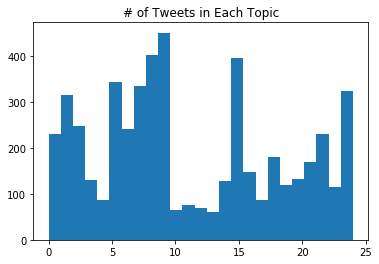

In [7]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print (documents[doc_index])
        print(" ")

# Run LDA
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', 
                                        learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_
display_topics(lda_H, lda_W, tf_feature_names, dfText, no_top_words, no_top_documents)


#  generate most probable topic for each tweet
topicList = []

for n in range(lda_W.shape[0]):
    topic_most_pr = lda_W[n].argmax()
    topicList.append(topic_most_pr)
#        print("doc: {} topic: {}\n".format(n,topic_most_pr))
    
#  merge back into tweets
df['topic'] = topicList


plt.hist(df['topic'], bins=no_topics)
plt.title('# of Tweets in Each Topic', fontdict=None, loc='center', pad=None)
plt.rcParams["figure.figsize"] = [12,9]
plt.show()


df2 = pd.DataFrame(lda_W)

output = pd.concat([df, df2], axis=1, sort=False)

out = pd.DataFrame(data=output)
out.to_csv('topics.csv', index_label=False)

out = pd.DataFrame(data=df2)
out.to_csv('ldaOut.csv', index_label=False)

#    df.topic.value_counts()[4]